In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.svm import SVC

In [4]:
df_over_1 = pd.read_csv("feaSubEOvert_1.csv", names = range(120))
df_over_2 = pd.read_csv("feaSubEOvert_2.csv", names = range(120))

df_img_1 = pd.read_csv("feaSubEImg_1.csv", names = range(120))
df_img_2 = pd.read_csv("feaSubEImg_2.csv", names = range(120))

df_BCI = pd.read_csv("BCIsensor_xy.csv", names = ["x", "y"])

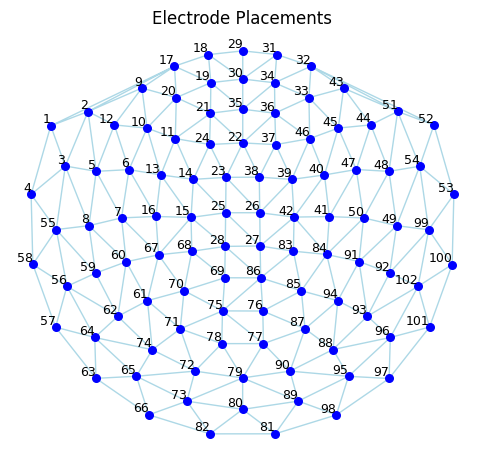

In [84]:
import matplotlib.tri as mtri
def plot_electrode_layout(df, annotate_indices=None, point_size=30):
    xs = df['x'].values
    ys = df['y'].values
    
    # Build a triangulation to connect nearest neighbors
    triang = mtri.Triangulation(xs, ys)
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.triplot(triang, color='lightblue', linewidth=1)
    ax.scatter(xs, ys, color='blue', s=point_size, zorder=2)
    
    # Annotate specific channels, if given
    if annotate_indices:
        for idx in annotate_indices:
            ax.text(xs[idx], ys[idx], str(idx+1),
                    fontsize=9, color='black', 
                    verticalalignment='bottom',
                    horizontalalignment='right')
    
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    ax.set_title("Electrode Placements")
    plt.show()

plot_electrode_layout(df_BCI, annotate_indices=range(102))

In [6]:
def convertToXY(df_class_1, df_class_2, trials = 120):
    X = []
    y = []
    for i in range(trials):
        X.append(np.array(df_class_1[i]))
        y.append(0)

        X.append(np.array(df_class_2[i]))
        y.append(1)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_svm_weight_topomap(model,
                            electrode_pos,
                            title,
                            grid_res=200,
                            point_size=20,           
                            circle_edgecolor='white',
                            circle_facecolor='none'):
    w = model.coef_.ravel()
    n_feat = w.size
    n_el   = len(electrode_pos)

    if n_feat == 2*n_el:
        w_el = np.sqrt(w[0::2]**2 + w[1::2]**2)
    

    xs = electrode_pos['x'].values
    ys = electrode_pos['y'].values

    xi = np.linspace(xs.min(), xs.max(), grid_res)
    yi = np.linspace(ys.min(), ys.max(), grid_res)
    Xi, Yi = np.meshgrid(xi, yi)

    Zi = griddata((xs, ys), w_el, (Xi, Yi), method='cubic')

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(Xi, Yi, Zi, shading='auto', cmap='viridis')
    plt.scatter(xs, ys,
                s=point_size,
                edgecolors=circle_edgecolor,
                facecolors=circle_facecolor,
                linewidths=1.2)
    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    pcm = plt.pcolormesh(Xi, Yi, Zi,
                         shading='auto',
                         cmap='viridis',
                         vmin=0,
                         vmax=w_el.max())

    cb = plt.colorbar(pcm, label='|weight|')
    cb.ax.tick_params(labelsize=10)

    plt.title(title, fontsize=14)   # added title
    plt.tight_layout()
    plt.show()


In [65]:
import numpy as np
import matplotlib.pyplot as plt

def plot_weight_stem_top6(model,
                          n_channels=204,
                          title="Signed SVM Weights Across Channels"):
    # 1) extract weight vector
    w = model.coef_.ravel()
    if w.size != n_channels:
        raise ValueError(f"Expected {n_channels} features, but model has {w.size}")

    # 2) identify top 6 by absolute magnitude
    abs_w = np.abs(w)
    top6_idx = np.argsort(abs_w)[-6:]                    # unsorted
    # sort them descending by abs value
    top6_idx = top6_idx[np.argsort(abs_w[top6_idx])[::-1]]
    top6 = [(int(i), float(w[i])) for i in top6_idx]

    # 3) create stem plot
    idxs = np.arange(n_channels)
    fig, ax = plt.subplots(figsize=(12, 4))
    markerline, stemlines, baseline = ax.stem(
        idxs, w, linefmt='-', markerfmt='o', basefmt='k-'
    )
    # style stems & baseline
    plt.setp(stemlines, color='tab:blue', linewidth=1)
    plt.setp(baseline, color='gray', linewidth=0.5)
    plt.setp(markerline, markersize=4, markeredgecolor='tab:blue', markerfacecolor='tab:blue')

    # 4) overlay top-6 points in red
    ax.scatter(top6_idx, w[top6_idx],
               s=60,
               c='red',
               marker='o',
               zorder=3,
               label='Top 6 |weights|')

    # 5) labels, grid, legend
    ax.set_xlabel("Channel Index", fontsize=12)
    ax.set_ylabel("Weight Value", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(np.arange(0, n_channels, step=10))
    ax.grid(which='both', linestyle='--', alpha=0.4)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return top6


In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score

def twoLevelCV_withROC(X, y, kernel='linear', alphas=[0.01, 1, 100, 10000], datatype = 'Overt'):
    outer_cv = StratifiedKFold(n_splits=6)

    # accumulators for total CV ROC
    all_y_true = []
    all_y_score = []

    # accumulators for overall accuracy
    overall_correct_count = 0
    overall_total_count   = 0

    plt.figure(figsize=(8, 6))

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        # --- inner CV to pick best C ---
        best_alpha = None
        best_acc   = -np.inf

        inner_cv = StratifiedKFold(n_splits=5)
        for alpha in alphas:
            inner_accs = []
            for tr_i, val_i in inner_cv.split(X_train, y_train):
                clf = SVC(kernel=kernel, C=alpha, probability=True)
                clf.fit(X_train[tr_i], y_train[tr_i])
                pred = clf.predict(X_train[val_i])
                pred = np.where(pred == -1, 0, pred)
                inner_accs.append(accuracy_score(y_train[val_i], pred))
            mean_acc = np.mean(inner_accs)
            if mean_acc > best_acc:
                best_acc   = mean_acc
                best_alpha = alpha

        # --- train on full train‐fold with best C ---
        final_clf = SVC(kernel=kernel, C=best_alpha, probability=True)
        final_clf.fit(X_train, y_train)

        if fold_idx == 1 and kernel == 'linear':
            plot_svm_weight_topomap(final_clf, df_BCI, title = f"SVM weights for fold 1 - {datatype} ")
            top_6 = plot_weight_stem_top6(final_clf)
            for i in range(6):
                print(f"Channel index {top_6[i][0]} with weight {top_6[i][1]}")
        # --- test‐fold predictions & scores ---
        probs = final_clf.predict_proba(X_test)[:, 1]
        preds = final_clf.predict(X_test)
        preds = np.where(preds == -1, 0, preds)

        # accumulate for overall ROC
        all_y_true.extend(y_test)
        all_y_score.extend(probs)

        # per‐fold ROC and AUC
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold_idx} (AUC={roc_auc:.2f})')

        # per‐fold accuracy
        fold_correct = np.sum(preds == y_test)
        fold_total   = len(y_test)
        fold_acc     = fold_correct / fold_total
        print(f'Fold {fold_idx} accuracy: {fold_acc:.3f}')

        # update overall accuracy counts
        overall_correct_count += fold_correct
        overall_total_count   += fold_total

    # --- total CV ROC ---
    fpr_tot, tpr_tot, _ = roc_curve(all_y_true, all_y_score)
    auc_tot = auc(fpr_tot, tpr_tot)
    plt.plot(fpr_tot, tpr_tot, 'k', lw=2, label=f'Total CV ROC (AUC={auc_tot:.2f})')

    # finalize plot
    plt.plot([0, 1], [0, 1], 'k:', lw=1)
    plt.xlim([0, 1]); plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f' {datatype} Per‐fold & Total Cross‐Validated ROC')
    plt.legend(loc='lower right'); plt.grid(True)
    plt.show()

    # --- overall accuracy ---
    overall_acc = overall_correct_count / overall_total_count
    print(f'Overall CV accuracy: {overall_acc:.3f}')


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

def cross_train(X_train, y_train, X_test, y_test, title,
                kernel='linear', alphas=[0.01, 1, 100, 10000]):
    # 1) find best C via 6-fold inner CV on the train split
    skf = StratifiedKFold(n_splits=6)
    best_alpha      = None
    best_probability = -np.inf

    for alpha in alphas:
        correct_preds = 0
        total_preds   = 0

        for train_idx, val_idx in skf.split(X_train, y_train):
            model = SVC(kernel=kernel, C=alpha)
            model.fit(X_train[train_idx], y_train[train_idx])

            pred_y = model.predict(X_train[val_idx])
            pred_y[pred_y == -1] = 0

            correct_preds += np.sum(pred_y == y_train[val_idx])
            total_preds   += len(pred_y)

        acc = correct_preds / total_preds
        if acc > best_probability:
            best_probability = acc
            best_alpha       = alpha

    # 2) train final model on ALL of X_train with best_alpha, *with* probabilities
    final_clf = SVC(kernel=kernel, C=best_alpha, probability=True)
    final_clf.fit(X_train, y_train)

    # 3) evaluate accuracy on X_test / y_test
    y_pred = final_clf.predict(X_test)
    y_pred[y_pred == -1] = 0
    acc = np.mean(y_pred == y_test)
    print(f"Accuracy: {acc:.3f}")

    # 4) build & plot ROC on the test set
    #    first make sure y_test is 0/1
    y0 = y_test.copy()
    y0[y0 == -1] = 0

    #    get class-1 probabilities
    y_score = final_clf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y0, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [10]:
X_img, y_img = convertToXY(df_img_1, df_img_2)
X_over, y_over = convertToXY(df_over_1, df_over_2)

<Figure size 800x600 with 0 Axes>

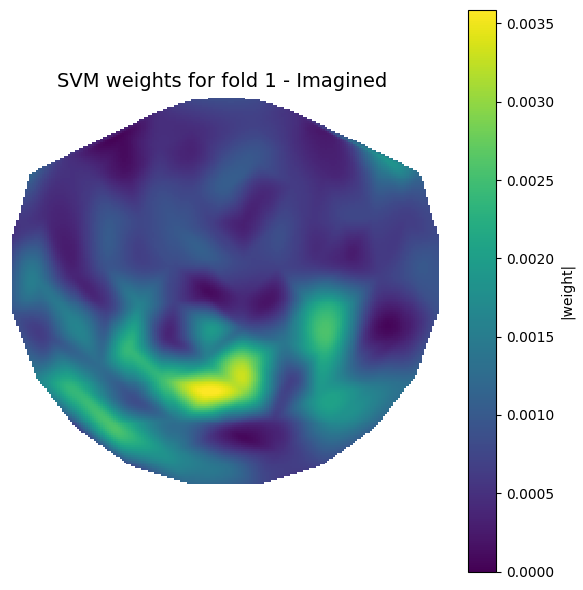

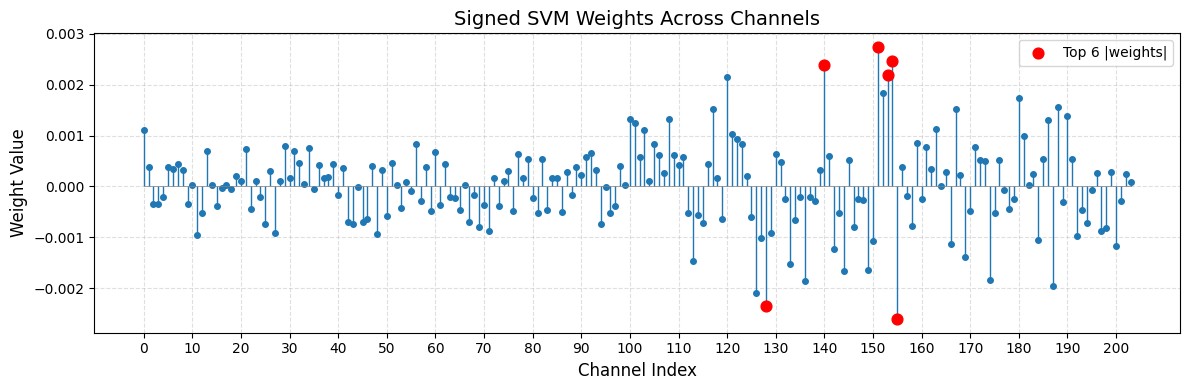

Channel index 151 with weight 0.0027434982672025036
Channel index 155 with weight -0.0026079150953474575
Channel index 154 with weight 0.0024609790728213326
Channel index 140 with weight 0.002384664146483011
Channel index 128 with weight -0.002343283287105509
Channel index 153 with weight 0.0021990552065590703
Fold 1 accuracy: 0.850
Fold 2 accuracy: 0.800
Fold 3 accuracy: 0.825
Fold 4 accuracy: 0.975
Fold 5 accuracy: 0.900
Fold 6 accuracy: 0.925


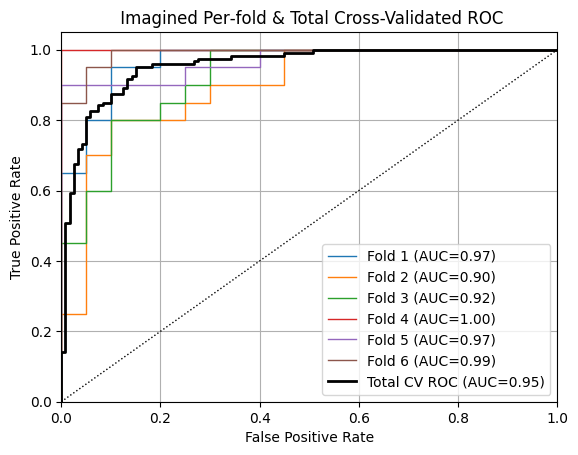

Overall CV accuracy: 0.879


In [86]:
twoLevelCV_withROC(X_img, y_img, datatype="Imagined") #scenario 2

<Figure size 800x600 with 0 Axes>

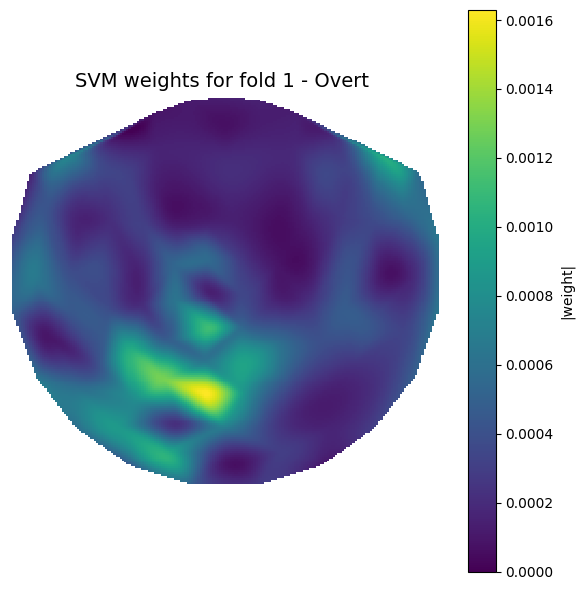

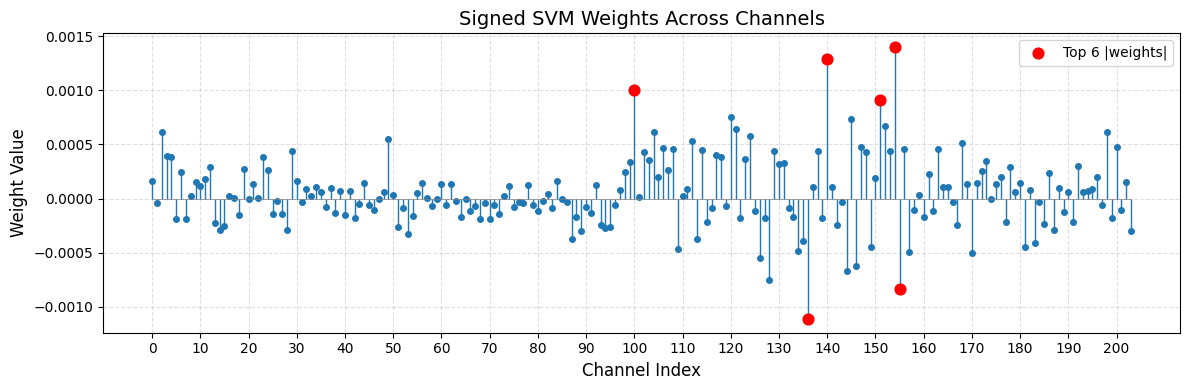

Channel index 154 with weight 0.0013991661693016477
Channel index 140 with weight 0.0012864876764058456
Channel index 136 with weight -0.0011121920248565295
Channel index 100 with weight 0.0009976389824055587
Channel index 151 with weight 0.0009137853321718927
Channel index 155 with weight -0.0008343862544072152
Fold 1 accuracy: 0.925
Fold 2 accuracy: 1.000
Fold 3 accuracy: 0.975
Fold 4 accuracy: 0.975
Fold 5 accuracy: 0.900
Fold 6 accuracy: 0.950


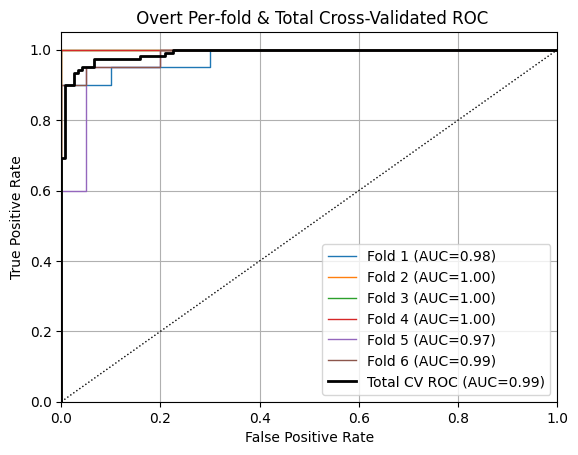

Overall CV accuracy: 0.954


In [87]:
twoLevelCV_withROC(X_over, y_over) #scenario 1

Accuracy: 0.912


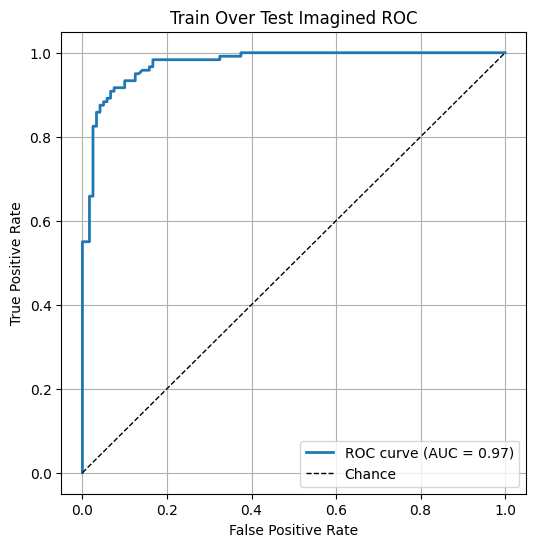

In [47]:
cross_train(X_img, y_img, X_over, y_over, title = "Train Over Test Imagined") #scenario 4   

Accuracy: 0.883


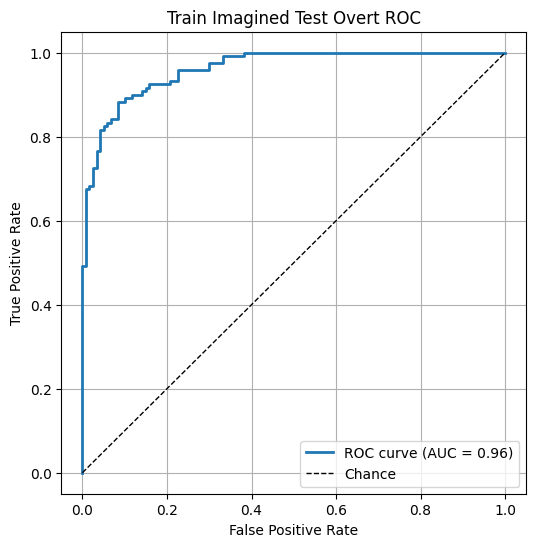

In [48]:
cross_train(X_over, y_over, X_img, y_img, title = "Train Imagined Test Overt") #scenario 3

Fold 1 accuracy: 0.900
Fold 2 accuracy: 0.775
Fold 3 accuracy: 0.775
Fold 4 accuracy: 0.875
Fold 5 accuracy: 0.825
Fold 6 accuracy: 0.800


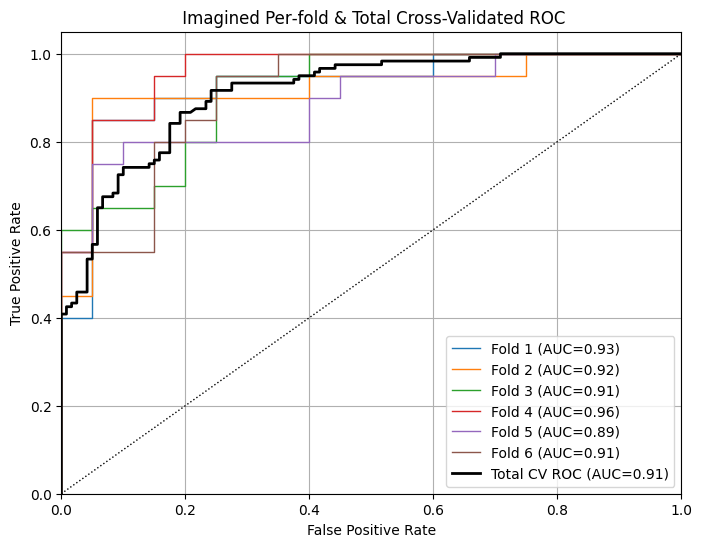

Overall CV accuracy: 0.825


In [72]:
twoLevelCV_withROC(X_img, y_img, kernel = 'rbf', datatype="Imagined") #scenario 2

Fold 1 accuracy: 0.800
Fold 2 accuracy: 1.000
Fold 3 accuracy: 0.975
Fold 4 accuracy: 0.975
Fold 5 accuracy: 0.875
Fold 6 accuracy: 0.925


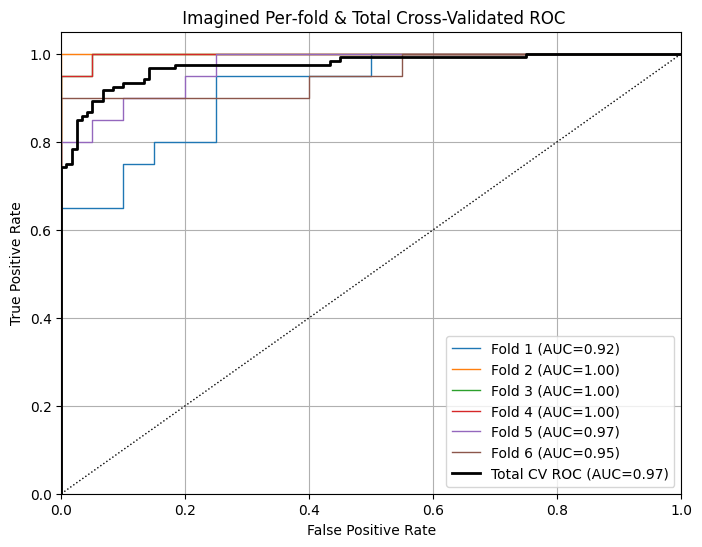

Overall CV accuracy: 0.925


In [73]:
twoLevelCV_withROC(X_over, y_over, kernel = 'rbf', datatype="Imagined") #scenario 1

Accuracy: 0.779


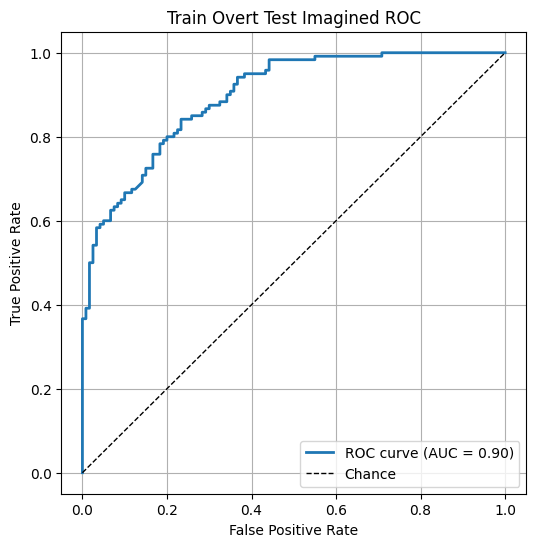

In [74]:
cross_train(X_over, y_over, X_img, y_img, title="Train Overt Test Imagined", kernel = 'rbf')

Accuracy: 0.887


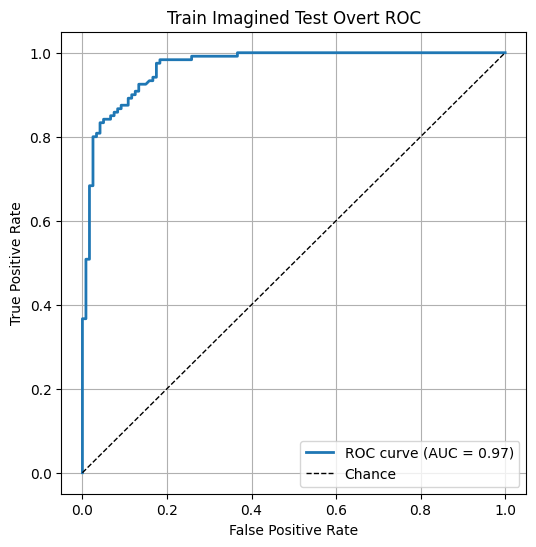

In [75]:
cross_train(X_img, y_img, X_over, y_over, title="Train Imagined Test Overt", kernel = 'rbf')